In [1]:
import sys, os, glob, random
sys.path.append('python/')
import numpy as np
import save_sklearn_gp as ssg
from scipy.linalg import cholesky, cho_solve

angles = ['00', '30', '45', '60', '75', '90']
angle = random.choice(angles)
while angle == '00' or angle == '90':
    angle = random.choice(angles)

files = glob.glob('theta'+angle+'deg/*')
files.sort() # sorting is necessary! otherwise time will be out of order

x_train = np.loadtxt(files[0]+'/model_X.dat') # all files have the same X training data - arbitrarily load from the first file
idx = random.choice(range(x_train.shape[0]))
while x_train[idx][-1] > 2200:
    idx = random.choice(range(x_train.shape[0]))
inputs = x_train[None, idx]

for file in files:
	fname = file+'/model'
	model = ssg.load_gp(fname) # loading Gaussian Process from hyperparameters saved in .json format
    
	K = model.kernel_(model.X_train_) # setting up the kernel
	K[np.diag_indices_from(K)] += model.alpha
	model.L_ = cholesky(K, lower=True) # recalculating L matrix since this is what makes the pickled models bulky
	model._K_inv = None # has to be set to None so the GP knows to re-calculate matrices used for uncertainty
	K_trans = model.kernel_(inputs, model.X_train_)
	pred = K_trans.dot(model.alpha_)
	pred = model._y_train_std * pred + model._y_train_mean
	v = cho_solve((model.L_, True), K_trans.T)
	y_cov = model.kernel_(inputs) - K_trans.dot(v)
	err = np.sqrt(np.diag(y_cov))
    
	sim = np.loadtxt(file+'/model_y.dat')[idx]
	sim *= model._y_train_std
	sim += model._y_train_mean
    
	try:
		lc = np.append(lc, pred)
		sim_lc = np.append(sim_lc, sim)
	except NameError:
		lc = pred # if first time point, initializes the light curve array
		sim_lc = sim


In [2]:
from kn_interp_angle import kn_interp_angle

offset = np.random.uniform(0, 15)
wavs = np.array([476., 621., 754., 900., 1020., 1220., 1630., 2190., 4493.])
bands = 'grizyJHK'
inputs = inputs.flatten()

os.environ["INTERP_LOC"] = './'

model = kn_interp_angle()

params = {"mej_dyn":inputs[0], "vej_dyn":inputs[1], "mej_wind":inputs[2], "vej_wind":inputs[3], "theta":int(angle)+offset}

t = np.logspace(np.log10(0.2), np.log10(7), 20)
b = bands[np.argmin(np.abs(wavs-inputs[-1]))]

model.set_params(params, (0, 0))

pred_above, err = model.evaluate(t, b)

model = kn_interp_angle()

params = {"mej_dyn":inputs[0], "vej_dyn":inputs[1], "mej_wind":inputs[2], "vej_wind":inputs[3], "theta":int(angle)-offset}

model.set_params(params, (0, 0))

pred_below, err = model.evaluate(t, b)

K band:
  evaluating time step 1 of 40
  evaluating time step 5 of 40
  evaluating time step 10 of 40
  evaluating time step 15 of 40
  evaluating time step 20 of 40
  evaluating time step 25 of 40
  evaluating time step 30 of 40
  evaluating time step 35 of 40
  evaluating time step 40 of 40
K band:
  evaluating time step 1 of 40
  evaluating time step 5 of 40
  evaluating time step 10 of 40
  evaluating time step 15 of 40
  evaluating time step 20 of 40
  evaluating time step 25 of 40
  evaluating time step 30 of 40
  evaluating time step 35 of 40
  evaluating time step 40 of 40


False


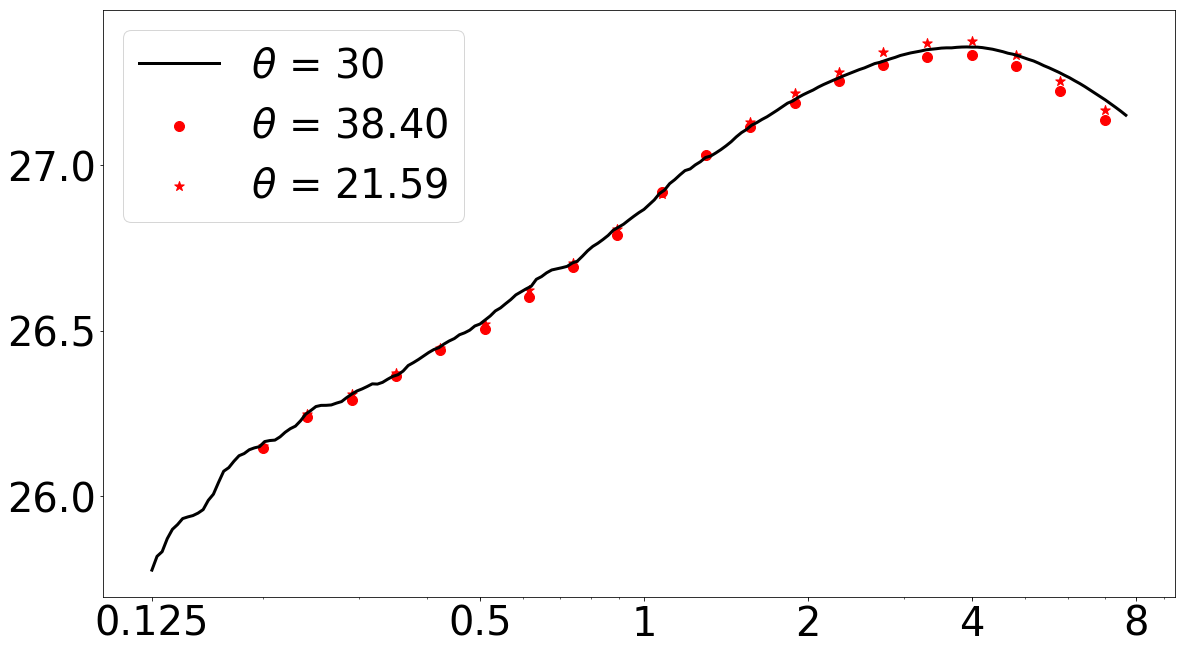

In [4]:
#import matplotlib
#matplotlib.use('Agg')
from matplotlib import ticker
import matplotlib.pyplot as plt
#%matplotlib inline

times = np.logspace(np.log10(0.125), np.log10(7.6608262), 191)

print(np.any(np.isin(t, times))) # verify that all user-requested times are different from interpolator time points

plt.rc('font', size = 40)
plt.rc('lines', lw=4)
plt.figure(figsize=(19.2, 10.8))
plt.plot(times, sim_lc, lw=3, c='k', label=r'$\theta$ = %s' % angle)
plt.scatter(t, pred_above, s=100, c='r', label=r'$\theta$ = %s' % str(float(angle)+offset)[:5])
plt.scatter(t, pred_below, s=100, c='r', marker='*', label=r'$\theta$ = %s' % str(float(angle)-offset)[:5])
plt.xscale("log")
plt.gca().set_xticks([0.125, 0.5, 1, 2, 4, 8])
plt.gca().get_xaxis().set_major_formatter(ticker.FormatStrFormatter('%g'))
plt.legend()
plt.show()